<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/Comparing_Dimensionality_Reduction_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install packages

In [1]:
!pip install torchcfm
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from umap import UMAP
from umap.plot import points
import umap

from tensorflow.keras.datasets import mnist

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,\
                            confusion_matrix,\
                            classification_report,\
                            silhouette_score

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,

# Config

In [4]:
image_size = 28
sample_size = 20000

In [5]:
savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [6]:
def get_mnist_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32')
  x_train /= 255
  x_train = x_train * 2 - 1
  x_test = x_test.astype('float32')
  x_test /= 255
  x_test = x_test * 2 - 1
  return x_train, y_train, x_test, y_test

In [7]:
X_train, y_train, X_test, y_test = get_mnist_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
components = [100, 200, 300, 400, 500] + list(range(501, 600, 5)) + [600, 784]
flat_X_train = X_train[:sample_size].reshape(len(X_train[:sample_size]), -1)

# Preprocessing

(60000, 28, 28)


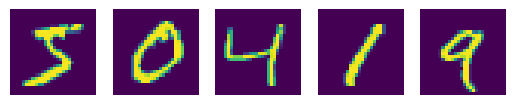

In [9]:
print(X_train.shape)
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

## Sobel Edge Detection

# Dimensionality Reduction

In [10]:
eval_metrics = dict()

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
evaluation_dict = {
    "method": list(),
    "reconstruction_mse": list(),
    "reconstruction_ssim": list(),
    "silhouette": list()
}

## Helpers

In [13]:
def eval_dim_reduc(model, flat_X, y, label:str):
  reconstruction_mse, reconstruction_ssim, silhouette = None, None, None

  # Transform the data
  if label == "TSNE":
    embeddings = model.fit_transform(flat_X)
  else:
    embeddings = model.transform(flat_X)
  embeddings_df = pd.DataFrame(embeddings, columns=[f"{label}1", f"{label}2"])

  # Plot it
  plt.scatter(x=embeddings_df[f"{label}1"],
              y=embeddings_df[f"{label}2"],
              s=5,
              c=y)
  plt.title(f"{label} projection")
  plt.show()

  flat_X = flat_X[:1000]
  y = y[:1000]

  if label != "TSNE":
    X_train_reduced_sets = list()
    X_train_reconstructed_sets = list()

    X_train_reduced = model.fit_transform(flat_X) # data transformed
    X_train_reduced_sets.append(X_train_reduced)
    X_train_reconstructed = model.inverse_transform(X_train_reduced) # data attempted to be reconstructed
    X_train_reconstructed_sets.append(X_train_reconstructed)

  eval_metrics = {
    "method": label,

    # get the mean squared error of the image reconstructions
    "reconstruction_mse": ((flat_X - X_train_reconstructed)**2).mean()\
                          if label != "TSNE" else None,

    # get the structural similarity of the image reconstructions
    "reconstruction_ssim": ssim(flat_X,
                               X_train_reconstructed,
                               data_range=X_train_reconstructed.max() - X_train_reconstructed.min())\
                            if label != "TSNE" else None,
    # get the silhouette score of the dimensionality-reduced clusters
    "silhouette": silhouette_score(embeddings[:1000], y)
  }

  return eval_metrics, embeddings

## PCA

In [14]:
PCA_model = PCA(n_components=2).fit(flat_X_train)

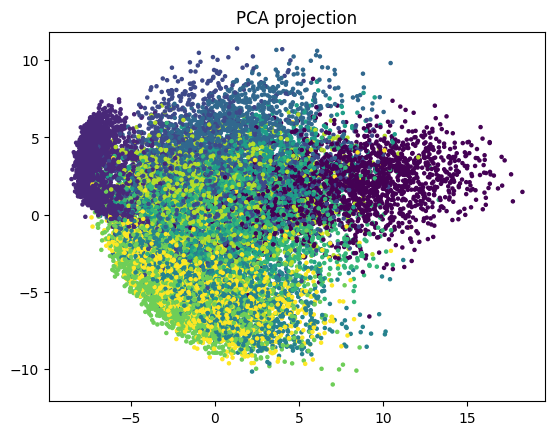

In [15]:
eval_metrics, pca_embeddings = eval_dim_reduc(
    PCA_model,
    flat_X_train,
    y_train[:sample_size],
    "PCA"
)
assert(len(eval_metrics.keys()) == len(evaluation_dict.keys()))
for k, v in eval_metrics.items():
  evaluation_dict[k].append(v)

## KPCA

In [16]:
KPCA_model = KernelPCA(n_components=2, fit_inverse_transform=True).fit(flat_X_train)

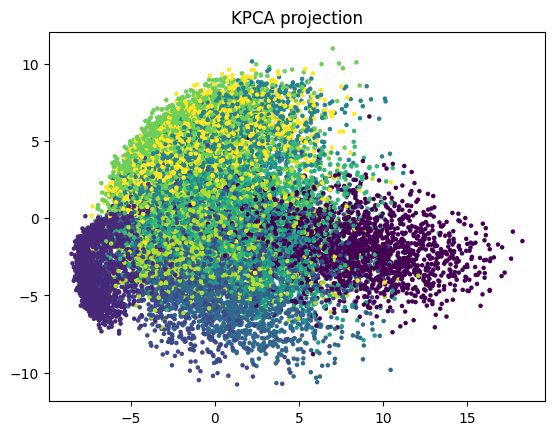

In [17]:
eval_metrics, kpca_embeddings = eval_dim_reduc(
    KPCA_model,
    flat_X_train,
    y_train[:sample_size],
    "KPCA"
)
assert(len(eval_metrics.keys()) == len(evaluation_dict.keys()))
for k, v in eval_metrics.items():
  evaluation_dict[k].append(v)

## UMAP

In [18]:
UMAP_model = UMAP(n_components=2, random_state=42).fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


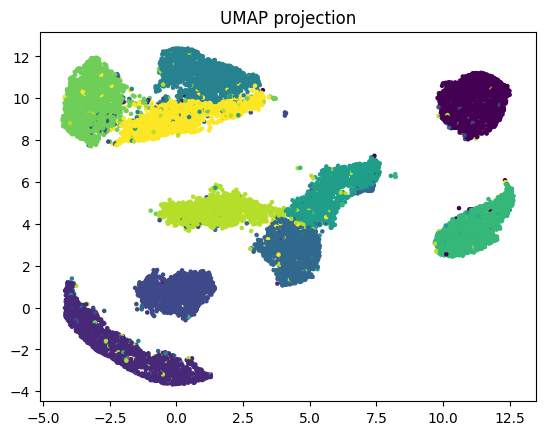

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
eval_metrics, umap_embeddings = eval_dim_reduc(
    UMAP_model,
    flat_X_train,
    y_train[:sample_size],
    "UMAP"
)

assert(len(eval_metrics.keys()) == len(evaluation_dict.keys()))
for k, v in eval_metrics.items():
  evaluation_dict[k].append(v)

## T-SNE

In [20]:
TSNE_model = TSNE(n_components=2, random_state=42)

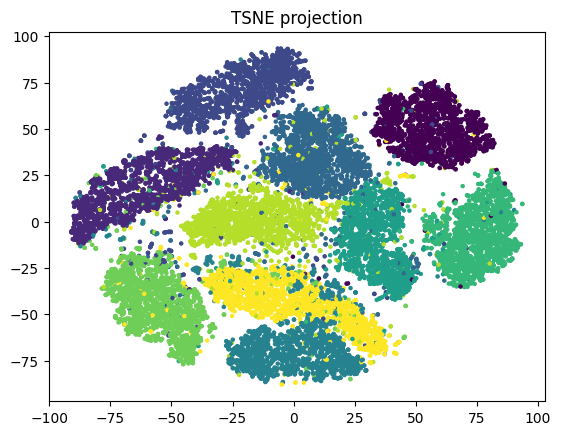

In [21]:
eval_metrics, tsne_embeddings = eval_dim_reduc(
    TSNE_model,
    flat_X_train,
    y_train[:sample_size],
    "TSNE"
)

assert(len(eval_metrics.keys()) == len(evaluation_dict.keys()))
for k, v in eval_metrics.items():
  evaluation_dict[k].append(v)

## Autoencoder

### Config

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

autoencoder_batch_size = 32

test_dataset = datasets.MNIST(
    "../data",
    train=False,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=autoencoder_batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=autoencoder_batch_size, shuffle=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.32MB/s]


### Autoencoder from [wikibook/keras](https://github.com/wikibook/keras/blob/master/chapter3-autoencoders/autoencoder-2dim-mnist-3.2.2.py)

In [23]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 7, 7)
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 7, 7)
        x = self.deconv(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


### Train the autoencoder

In [24]:
train_losses = []

latent_dim = 2
autoencoder = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

if os.path.exists(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")) and False:
    autoencoder.load_state_dict(torch.load(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")))

else:
  n_epochs = 20
  for epoch in range(n_epochs):
      autoencoder.train()
      running_loss = 0
      for i, batch in enumerate(train_loader):
          imgs, _ = batch
          imgs = imgs.to(device)

          optimizer.zero_grad()
          outputs = autoencoder(imgs)
          loss = criterion(outputs, imgs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")
      avg_loss = running_loss / len(train_loader)
      train_losses.append(avg_loss)
      print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss:.4f}")
  torch.save(autoencoder.state_dict(), os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt"))

 epoch: 0, steps: 1874, loss: 0.2046Epoch [1/20], Loss: 402.6418
 epoch: 1, steps: 1874, loss: 0.2074Epoch [2/20], Loss: 366.0148
 epoch: 2, steps: 1874, loss: 0.1728Epoch [3/20], Loss: 356.3435
 epoch: 3, steps: 1874, loss: 0.2022Epoch [4/20], Loss: 349.8884
 epoch: 4, steps: 1874, loss: 0.1845Epoch [5/20], Loss: 345.6650
 epoch: 5, steps: 1874, loss: 0.1718Epoch [6/20], Loss: 342.6233
 epoch: 6, steps: 1874, loss: 0.1889Epoch [7/20], Loss: 339.9462
 epoch: 7, steps: 1874, loss: 0.1664Epoch [8/20], Loss: 338.0516
 epoch: 8, steps: 1874, loss: 0.1704Epoch [9/20], Loss: 336.2789
 epoch: 9, steps: 1874, loss: 0.1774Epoch [10/20], Loss: 335.0456
 epoch: 10, steps: 1874, loss: 0.1847Epoch [11/20], Loss: 333.7027
 epoch: 11, steps: 1874, loss: 0.1629Epoch [12/20], Loss: 332.7225
 epoch: 12, steps: 1874, loss: 0.1819Epoch [13/20], Loss: 331.7164
 epoch: 13, steps: 1874, loss: 0.1558Epoch [14/20], Loss: 330.7693
 epoch: 14, steps: 1874, loss: 0.1559Epoch [15/20], Loss: 329.9895
 epoch: 15, st

### Evaluate the autoencoder

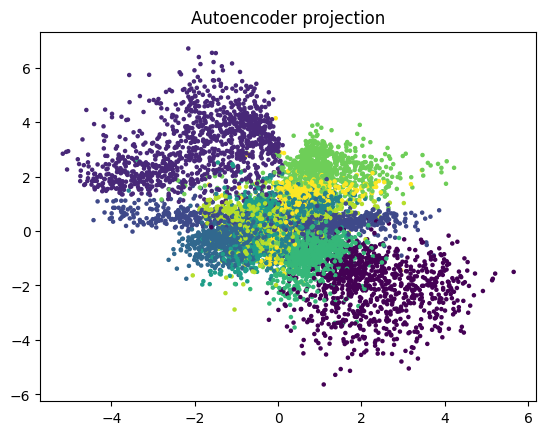

In [25]:
autoencoder.encoder.eval()
zs = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        z = autoencoder.encoder(x)
        zs.append(z.cpu())
        labels.append(y)
zs = torch.cat(zs)
labels = torch.cat(labels)

plt.scatter(x=zs[:, 0],
            y=zs[:, 1],
            s=5,
            c=labels)
plt.title("Autoencoder projection")
plt.show()

autoencoder.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)[:1000]
    outputs = autoencoder(imgs)

imgs = imgs.cpu().numpy()
outputs = outputs.cpu().numpy()
comparison = np.concatenate([imgs, outputs])

eval_metrics = {
  "method": "Autoencoder",

  # get the mean squared error of the image reconstructions
  "reconstruction_mse": ((imgs - outputs)**2).mean(),

  # # get the structural similarity of the image reconstructions
  "reconstruction_ssim": None,
  # "reconstruction_ssim": ssim(imgs,
  #                             outputs,
  #                             data_range=outputs.max() - outputs.min(),
  #                             win_size=7),

  # get the silhouette score of the dimensionality-reduced clusters
  "silhouette": silhouette_score(zs[:1000], labels[:1000])
}

assert(len(eval_metrics.keys()) == len(evaluation_dict.keys()))
for k, v in eval_metrics.items():
  evaluation_dict[k].append(v)

# Compare Dimensionality Reduction Techniques

In [26]:
evaluation_df = pd.DataFrame(evaluation_dict)
evaluation_df.head()

,method,reconstruction_mse,reconstruction_ssim,silhouette
0,PCA,0.216654,0.550654,0.010105
1,KPCA,0.878704,0.002707,0.010106
2,UMAP,0.286782,0.137087,0.471807
3,TSNE,NaN,NaN,0.359920
4,Autoencoder,0.158139,NaN,0.023918


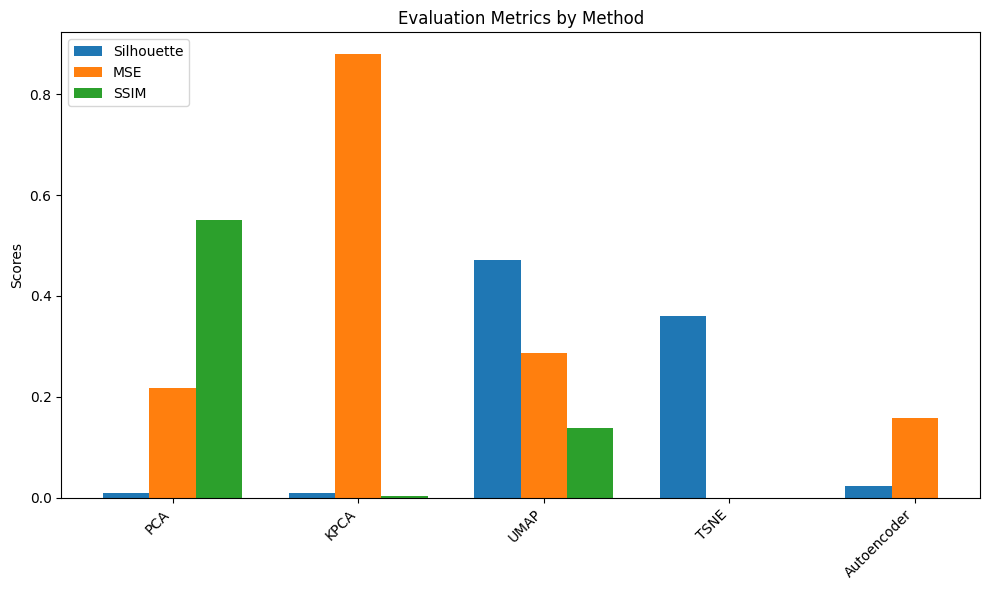

In [27]:
# Define the positions and width for the bars
methods = evaluation_df["method"]
x = np.arange(len(methods))  # the label locations
width = 0.25  # the width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, evaluation_df["silhouette"], width, label='Silhouette')
bars2 = ax.bar(x, evaluation_df["reconstruction_mse"], width, label='MSE')
bars3 = ax.bar(x + width, evaluation_df["reconstruction_ssim"], width, label='SSIM')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Compare Variants of PCA + UMAP

In [28]:
evaluation_dict = {
    "method": list(),
    "reconstruction_mse": list(),
    "reconstruction_ssim": list(),
    "silhouette": list(),
    "percent_dims_reduced_by_pca": list()
}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


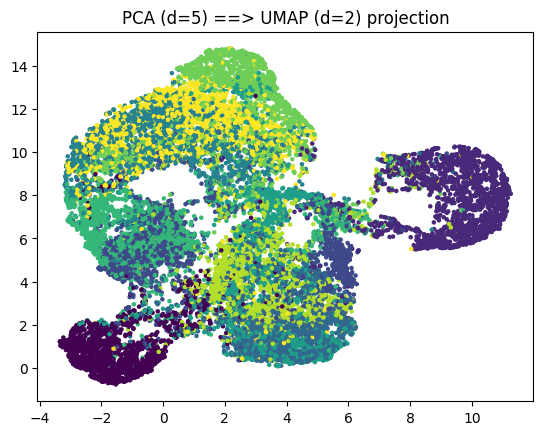

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


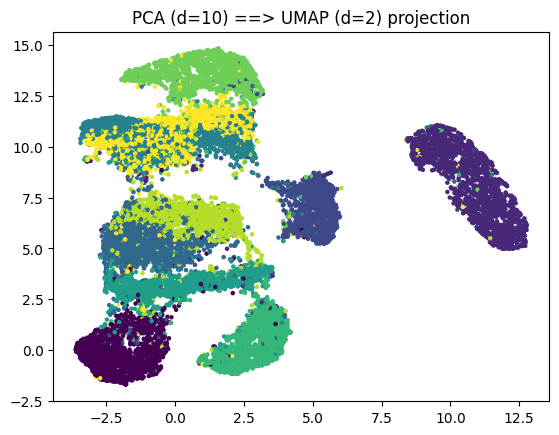

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


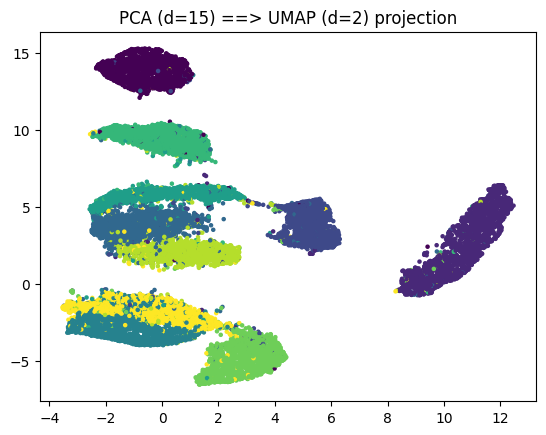

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


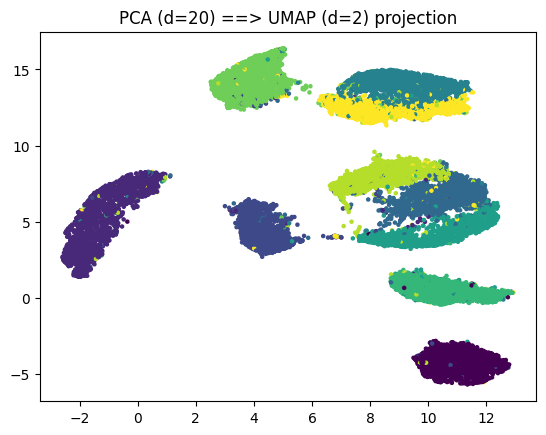

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


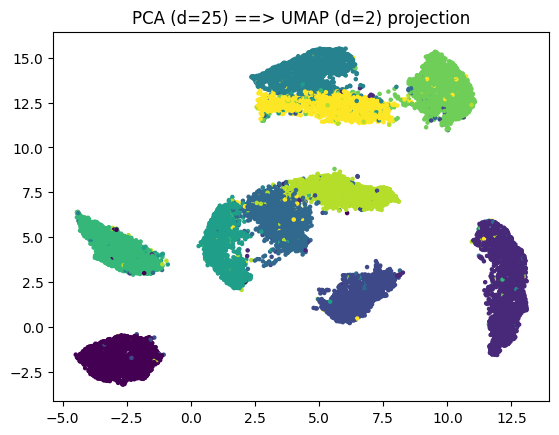

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


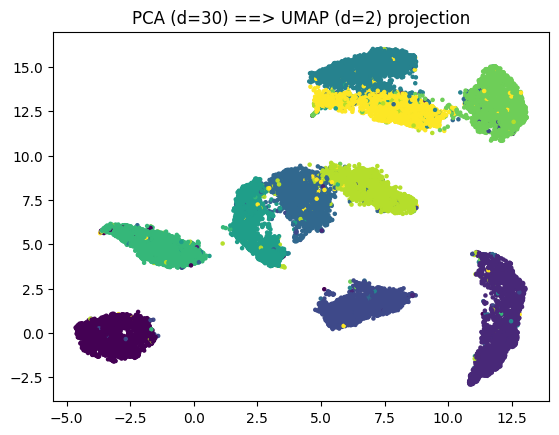

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


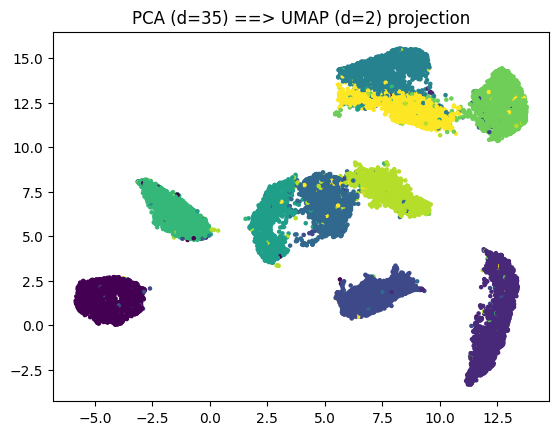

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


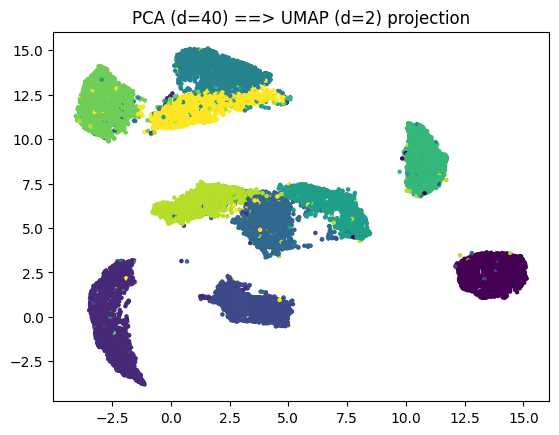

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


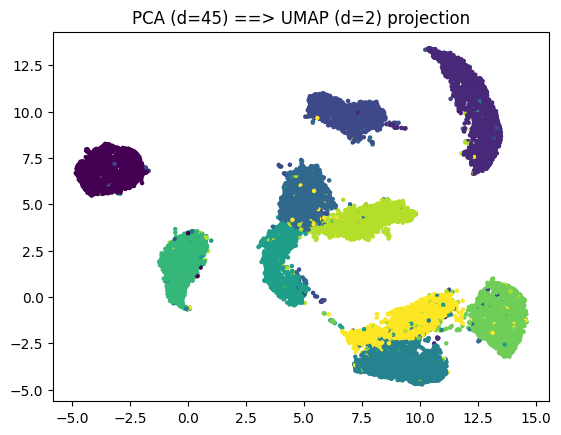

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


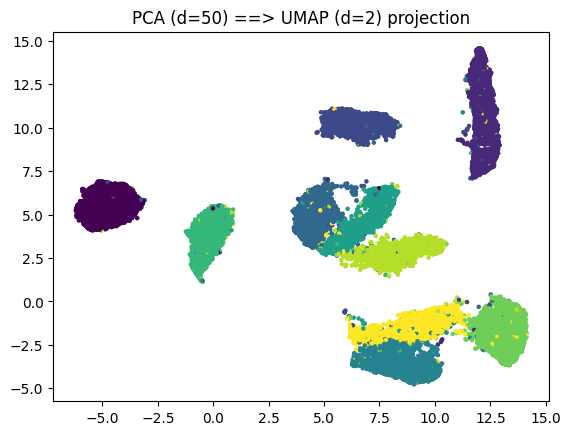

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


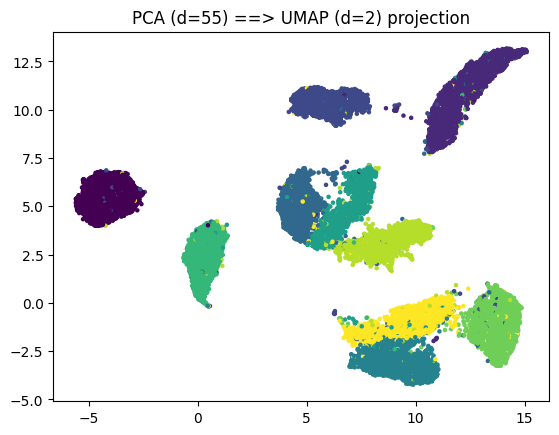

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
for i in range(1, 12):
  n_components = i*5
  dim_reduc_pipeline = Pipeline([
      ("PCA", PCA(n_components=n_components)),
      ("UMAP", UMAP(n_components=2, random_state=42))
  ])
  dim_reduc_pipeline = dim_reduc_pipeline.fit(flat_X_train)

  label = f"PCA (d={n_components}) ==> UMAP (d=2)"
  eval_metrics, pca_umap_embeddings = eval_dim_reduc(
    dim_reduc_pipeline,
    flat_X_train,
    y_train[:sample_size],
    label
  )

  assert(len(eval_metrics.keys()) == len(evaluation_dict.keys())-1)
  for k, v in eval_metrics.items():
    evaluation_dict[k].append(v)

  evaluation_dict["percent_dims_reduced_by_pca"].append(
      float(n_components)/float(782)
  )

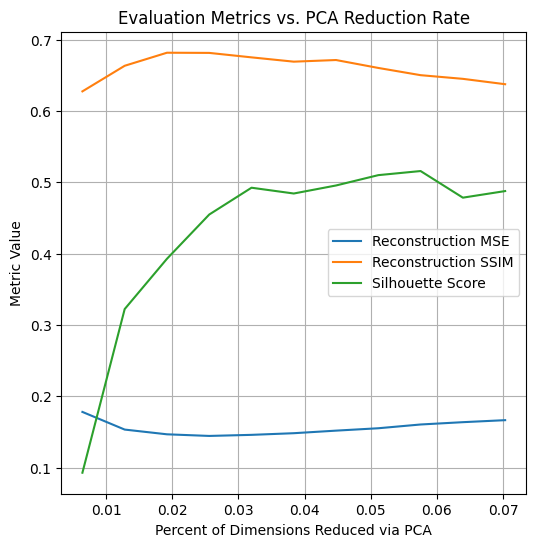

In [30]:
plt.figure(figsize=(6, 6))

plt.plot(evaluation_dict["percent_dims_reduced_by_pca"], evaluation_dict["reconstruction_mse"], label="Reconstruction MSE")
plt.plot(evaluation_dict["percent_dims_reduced_by_pca"], evaluation_dict["reconstruction_ssim"], label="Reconstruction SSIM")
plt.plot(evaluation_dict["percent_dims_reduced_by_pca"], evaluation_dict["silhouette"], label="Silhouette Score")

plt.xlabel("Percent of Dimensions Reduced via PCA")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics vs. PCA Reduction Rate")
plt.legend()
plt.grid(True)
plt.show()

# Final Model

## Dimensionality Reduction

In [31]:
final_pipeline = Pipeline([
    ("PCA", PCA(n_components=40)),
    ("UMAP", UMAP(n_components=2, random_state=42))
])
label = "PCA (d=40) ==> UMAP (d=2)"
final_pipeline = final_pipeline.fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [32]:
reduced_mnist = final_pipeline.fit_transform(flat_X_train)
reduced_mnist_df = pd.DataFrame(reduced_mnist)

reduced_mnist_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1
0,6.500267,6.396587
1,13.368768,2.101022
2,3.767967,13.605200
3,-1.881207,-2.746832
4,1.144917,11.958029


## Visualizations
Show samples from that latent space

[Code originally from here](https://umap-learn.readthedocs.io/en/latest/inverse_transform.html)

In [33]:
final_pipeline

Pipeline(steps=[('PCA', PCA(n_components=40)),
                ('UMAP',
                 UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])

In [34]:
grid_size = 15

corners = np.array([
    [-3, -3],
    [-3, 15],
    [16, 2],
    [4.5, 15],
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, grid_size)
    for x in np.linspace(0, 1, grid_size)
])

In [35]:
inv_transformed_points = final_pipeline.inverse_transform(test_pts)

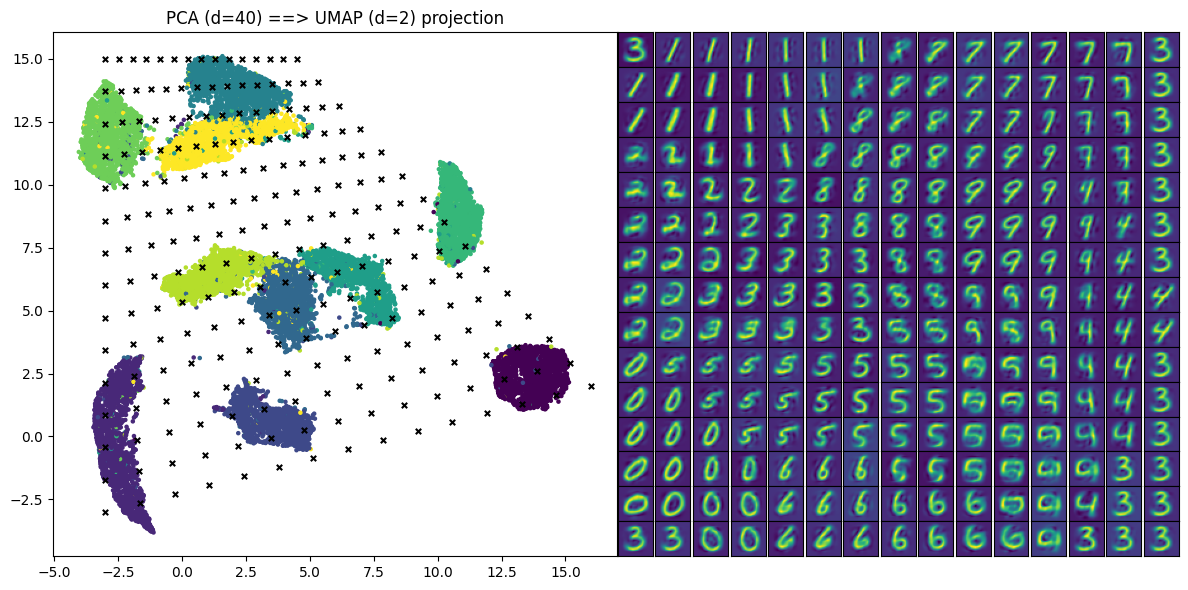

In [36]:
# Set up the grid
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(grid_size, 2 * grid_size, fig)
# Set all padding in GridSpec to 0
gs.update(wspace=0, hspace=0)
scatter_ax = fig.add_subplot(gs[:, :grid_size])
digit_axes = np.zeros((grid_size, grid_size), dtype=object)

for i in range(grid_size):
    for j in range(grid_size):
        digit_axes[i, j] = fig.add_subplot(gs[i, grid_size + j])

# Plot projection onto the scatter axis (use scatter_ax, not plt)
scatter_ax.scatter(x=reduced_mnist_df[0],
                   y=reduced_mnist_df[1],
                   s=5,
                   c=y_train[:sample_size])
scatter_ax.set_title(f"{label} projection")

# Plot test points
scatter_ax.scatter(test_pts[:, 0],
                   test_pts[:, 1],
                   marker='x',
                   c='k',
                   s=15)

# Plot each of the generated digit images
for i in range(grid_size):
    for j in range(grid_size):
        ax = digit_axes[i, j]
        ax.imshow(inv_transformed_points[i * grid_size + j].reshape(28, 28))
        ax.set(xticks=[], yticks=[])

# Show everything at once
plt.tight_layout()
plt.show()